Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

In [75]:
#Для начала взглянем на данные:

In [76]:
import pandas as pd
import seaborn as sns
import pingouin as pg
from scipy.stats import mannwhitneyu
import scipy.stats as stats
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.close("all")

In [77]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
group_add = pd.read_csv('Проект_2_group_add.csv')
active_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [78]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [79]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [80]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [81]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### 1.На какие метрики Вы смотрите в ходе анализа и почему?

Для проверки теста я буду анализировать ARPPU.
Для начала отфильтруем отдельно тестовую и контрольную группы

In [82]:
full_group = groups.merge(group_add, how='outer') # соединяем два датафрейма для полной картины
full_group = full_group.rename(columns={'id': 'student_id'}) # переименовываем колонку для последующего merge-a

active_users = full_group.merge(active_studs, how='right', on='student_id')
# находим среди экспериментальных групп клиентов, которые зашли на платформу в дни проведения эксперимента

dfs = active_users.merge(checks, how='right', on='student_id') 
# находим пользователей, которые купили товар среди тех, кто посещал страницу в период эксперимента

clients_with_checks = dfs.dropna() # избавляемся от тех, кто не состоит в эксперименте
# далее формируем разбиваем группы на отдельные датафреймы
rev_A = clients_with_checks.query("grp == 'A'") 
rev_B = clients_with_checks.query("grp == 'B'")

In [83]:
clients_with_checks

,student_id,grp,rev
0,1627,A,990.0000
4,100300,B,990.0000
8,108270,B,290.0000
26,264473,B,1900.0001
27,274352,B,690.0000
...,...,...,...
536,5645737,B,1900.0000
537,5651566,B,1900.0000
538,5662322,B,1900.0000
539,5681918,B,1900.0000


In [84]:
# Проверим наши группы на нормальность

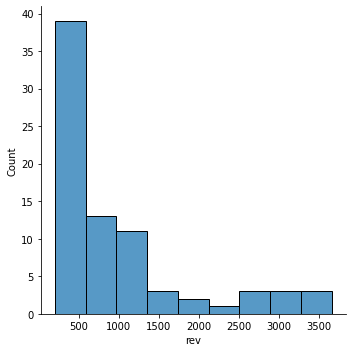

In [85]:
sns.displot(clients_with_checks[clients_with_checks.grp == 'A'].rev, kde=False)

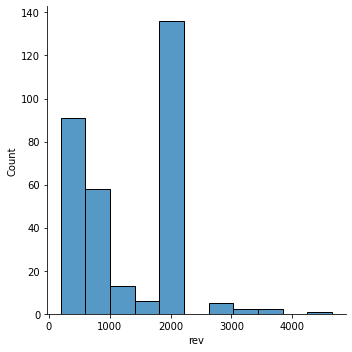

In [86]:
sns.displot(clients_with_checks[clients_with_checks.grp == 'B'].rev, kde=False)

In [87]:
# либо с помощью pg.normality:
pg.normality(data=clients_with_checks, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


In [88]:
# Как видим, группы распределены ненормально-это значит, что нельзя использовать t-test.
# Используем U-тест Манна-Уитни (он менее чувствителен к выбросам)
#mannwhitneyu(clients_with_checks[clients_with_checks.grp == 'A'].rev, 
#            clients_with_checks[clients_with_checks.grp == 'B'].rev)

### ARPPU = Revenue / Paying users

In [89]:
revenue = clients_with_checks.rev.sum()
ARPPU_A = revenue / rev_A.rev
ARPPU_B = revenue / rev_B.rev

In [90]:
#Как видим, группы распределены ненормально-это значит, что нельзя использовать t-test.
# Используем U-тест Манна-Уитни (он менее чувствителен к выбросам)
mannwhitneyu(ARPPU_A, 
            ARPPU_B)

MannwhitneyuResult(statistic=15491.0, pvalue=0.0002511393831406922)

### P-value < 0.05- отклоняем нулевую гипотезу- различия в ARPPU имеются

## Вывод: Проведя эксперимент,  мы можем сделать вывод,  что однозначно стоит запускать новую механику оплаты на всех пользователей

### №3 
### Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [144]:
def load_data():
    groups = pd.read_csv('Проект_2_groups.csv', sep=';')
    group_add = pd.read_csv('Проект_2_group_add.csv')
    active_studs = pd.read_csv('Проект_2_active_studs.csv')
    checks = pd.read_csv('Проект_2_checks.csv', sep=';')   
    full_group = groups.merge(group_add, how='outer') # соединяем два датафрейма для полной картины
    full_group = full_group.rename(columns={'id': 'student_id'}) # переименовываем колонку для последующего merge-a

    active_users = full_group.merge(active_studs, how='right', on='student_id')
# находим среди экспериментальных групп клиентов, которые зашли на платформу в дни проведения эксперимента

    dfs = active_users.merge(checks, how='right', on='student_id') 
# находим пользователей, которые купили товар среди тех, кто посещал страницу в период эксперимента

    clients_with_checks = dfs.dropna() # избавляемся от тех, кто не состоит в эксперименте
# далее формируем разбиваем группы на отдельные датафреймы
    rev_A = clients_with_checks.query("grp == 'A'") 
    rev_B = clients_with_checks.query("grp == 'B'")
    revenue = clients_with_checks.rev.sum()
    d = {'ARPPU_A': (revenue / rev_A.rev), 'ARPPU_B': (revenue / rev_B.rev)}
    df = pd.DataFrame(data=d)
    df['ARPPU_A'] = df['ARPPU_A'].round(2)
    return(df)